In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pii-detection-removal-from-educational-data/sample_submission.csv
/kaggle/input/pii-detection-removal-from-educational-data/train.json
/kaggle/input/pii-detection-removal-from-educational-data/test.json
/kaggle/input/gemma-generated-data/Gemma_generated_data.json
/kaggle/input/gemma-generated-data/Gemma_generated_data_2.csv


In [ ]:
import json
import argparse
from itertools import chain
from functools import partial

import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification, DataCollatorForTokenClassification
#import evaluate
from datasets import Dataset, features
import numpy as np


In [ ]:
import json

# Paths to JSON files
json_file1  = "/kaggle/input/pii-detection-removal-from-educational-data/train.json"
json_file2  = "/kaggle/input/gemma-generated-data/Gemma_generated_data.json"


In [ ]:
df1 = pd.read_json(json_file1)
print(len(df1))
df2 = pd.read_json(json_file2)
print(len(df2))
combined_df = pd.concat([df1, df2], ignore_index=True)
print(len(combined_df))

6807
500
7307


In [ ]:
# Save the combined DataFrame to a new JSON file
combined_json_file = "combined_data.json"
combined_df.to_json(combined_json_file, orient='records')

In [ ]:
# Workflow essentials
import gc
import json
import torch
import random
import argparse
from itertools import chain
from functools import partial
from datasets import Dataset, features

# Data preprocessing and visualization
import numpy as np
import pandas as pd

# Model development
from sklearn.metrics import f1_score
from transformers import AutoModel, AutoTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification

In [ ]:
class CFG:
    # Paths to datasets
    comp_data = '/kaggle/input/pii-detection-removal-from-educational-data/train.json'
    ext_data = '/kaggle/input/gemma-generated-data/Gemma_generated_data.json'

    # Model paths for loading and saving
    checkpoint = 'microsoft/deberta-v3-base'
    output_name = 'deberta3base'
    output_dir = 'output'

    # Data preprocessing
    downsample = 0.29
    max_len = 512
    workers = 8

    # Model params
    learning_rate = 2e-5
    weight_decay = 0.01
    warmup_ratio = 0.1
    batch_size = 2
    grad_steps = 2
    log_steps = 100
    epochs = 3

    # Global seed
    seed = 457

In [ ]:
def global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

In [ ]:
global_seed(CFG.seed)
gc.collect()

7958

In [ ]:
class DataPreprocessor:
    def load_clean_concat_data(self, path1, path2, downsample, max_length, seed):
        # Load JSON data as pandas DataFrames
        df1 = pd.read_json(path1)
        df2 = pd.read_json(path2)

        # Concatenate both DataFrames
        concat_df = pd.concat([df1, df2], ignore_index=True)

        # Display the shape of the DataFrame before filtering
        print(f"Shape of DataFrame before filtering: {concat_df.shape}")

        # Identify rows with positive PII labels
        concat_df['has_positive_PII'] = concat_df['labels'].apply(lambda x: any(label.startswith('B-') or label.startswith('I-') for label in x))

        # Downsample rows without positive PII labels
        df_without_positive_PII = concat_df[~concat_df['has_positive_PII']].sample(frac=downsample, random_state=seed)

        # Concatenate rows with positive PII labels and downsampled rows without positive PII labels
        concat_df = pd.concat([concat_df[concat_df['has_positive_PII']], df_without_positive_PII])

        # Drop the auxiliary column used for filtering
        concat_df.drop(columns=['has_positive_PII'], inplace=True)

        # Display the shape of the DataFrame after filtering
        print(f"Shape of DataFrame after filtering: {concat_df.shape}")
        display(concat_df.head())

        # Count essays with lengths smaller and longer than max_length
        smaller_than_max_len = concat_df[concat_df['tokens'].apply(len) <= max_length]['tokens'].count()
        longer_than_max_len = concat_df[concat_df['tokens'].apply(len) > max_length]['tokens'].count()

        # Calculate the percentage of essays with length longer than max_length
        total_essays = concat_df['tokens'].count()
        percentage_longer_than_max = (longer_than_max_len / total_essays) * 100

        # Create a DataFrame to display counts
        counts_df = pd.DataFrame({
            'Token Length': [f'Shorter than {max_length}', f'Longer than {max_length}'],
            'Count': [smaller_than_max_len, longer_than_max_len]
        })

        # Display counts
        display(counts_df)

        # Print the percentage of essays with length longer than max_length
        print(f"Percentage of essays longer than {max_length} tokens: {percentage_longer_than_max:.2f}%")

        # Convert DataFrame back to JSON format
        json_data = concat_df.to_json(orient='records')

        # Convert JSON data back to list of dictionaries
        data = json.loads(json_data)

        # Return data
        return data

    def tokenize(self, example, tokenizer, label2id, max_length):
        # Initialize empty lists to store tokens and corresponding labels
        text, labels = [], []

        # Iterate over each token, label, and whitespace indicator in the example
        for token, label, whitespace in zip(example["tokens"], example["provided_labels"], example["trailing_whitespace"]):
            text.append(token)
            labels.extend([label] * len(token))  # Extend labels for each token

            # Append whitespace if present after the token
            if whitespace:
                text.append(" ")
                labels.append("O")  # Add 'O' label for whitespace

        # Reconstruct the text from tokens
        text = "".join(text)

        # Tokenize the text
        tokenized = tokenizer(text,
                              return_offsets_mapping=True,
                              truncation=True,
                              max_length=max_length)

        # Initialize list to store labels assigned to each token
        token_labels = []

        # Iterate over token offset mappings
        for start_idx, end_idx in tokenized.offset_mapping:
            # Handle special case of CLS token
            if start_idx == 0 and end_idx == 0:
                token_labels.append(label2id["O"])
                continue

            # Adjust start index if token starts with whitespace
            if text[start_idx].isspace():
                start_idx += 1

            # Assign label ID to token based on start index
            token_labels.append(label2id[labels[start_idx]])

        # Calculate length of tokenized input sequence
        length = len(tokenized.input_ids)

        # Construct tokenized data dictionary
        tokenized_data = {
            "input_ids": tokenized.input_ids,
            "attention_mask": tokenized.attention_mask,
            "labels": token_labels,
            "length": length
        }

        return tokenized_data

# Initialize the DataPreprocessor
dp = DataPreprocessor()

In [ ]:
data = dp.load_clean_concat_data(CFG.comp_data, CFG.ext_data, CFG.downsample, CFG.max_len, CFG.seed)

Shape of DataFrame before filtering: (7307, 5)
Shape of DataFrame after filtering: (3144, 5)


,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


,Token Length,Count
0,Shorter than 512,1085
1,Longer than 512,2059


Percentage of essays longer than 512 tokens: 65.49%


In [ ]:
# Define a function to create the desired DataFrame
def create_dataframe_for_documents(data, document_ids):
    # Initialize empty lists to store document, token position, and label
    documents_list, token_positions_list, labels_list = [], [], []

    # Iterate over each data entry
    for entry in data:
        if entry["document"] in document_ids and any(label.startswith('B-') or label.startswith('I-') for label in entry["labels"]):
            # Find the positions of tokens with positive PII labels
            positive_pii_positions = [i for i, label in enumerate(entry["labels"]) if label.startswith('B-') or label.startswith('I-')]

            # Append data to lists
            documents_list.append(entry["document"])
            token_positions_list.append(positive_pii_positions)
            labels_list.append(entry["labels"])

    # Create a DataFrame from the lists
    df = pd.DataFrame({
        "Document": documents_list,
        "Token Positions": token_positions_list,
        "Labels": labels_list
    })

    return df

In [ ]:
# List of document IDs to include in the DataFrame
document_ids = [7, 10, 16, 20, 56, 86, 93, 104, 112, 123]

# Create the DataFrame using the function
df_new = create_dataframe_for_documents(data, document_ids)

# Display the new DataFrame
display(df_new)

,Document,Token Positions,Labels
0,7,"[9, 10, 482, 483, 741, 742]","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,"[0, 1, 464, 465]","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,"[4, 5]","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,"[5, 6]","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,"[12, 13]","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."
5,86,"[6, 7]","[O, O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUD..."
6,93,"[0, 1]","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
7,104,"[8, 9]","[O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-NAM..."
8,112,"[5, 6]","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
9,123,"[32, 33]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [ ]:
# Function to extract labels based on token positions
def extract_labels(row):
    return [row['Labels'][pos] for pos in row['Token Positions']]

# Apply the function to create a new column 'Extracted Labels'
df_new['Extracted Labels'] = df_new.apply(extract_labels, axis=1)

# Display the new DataFrame
print(df_new[['Document', 'Token Positions', 'Extracted Labels']])

   Document              Token Positions  \
0         7  [9, 10, 482, 483, 741, 742]   
1        10             [0, 1, 464, 465]   
2        16                       [4, 5]   
3        20                       [5, 6]   
4        56                     [12, 13]   
5        86                       [6, 7]   
6        93                       [0, 1]   
7       104                       [8, 9]   
8       112                       [5, 6]   
9       123                     [32, 33]   

                                    Extracted Labels  
0  [B-NAME_STUDENT, I-NAME_STUDENT, B-NAME_STUDEN...  
1  [B-NAME_STUDENT, I-NAME_STUDENT, B-NAME_STUDEN...  
2                   [B-NAME_STUDENT, I-NAME_STUDENT]  
3                   [B-NAME_STUDENT, I-NAME_STUDENT]  
4                   [B-NAME_STUDENT, I-NAME_STUDENT]  
5                   [B-NAME_STUDENT, I-NAME_STUDENT]  
6                   [B-NAME_STUDENT, I-NAME_STUDENT]  
7                   [B-NAME_STUDENT, I-NAME_STUDENT]  
8                   

In [ ]:
# Create lists to hold new data
new_token_positions = []
new_labels = []

# Iterate over rows
for index, row in df_new.iterrows():
    token_positions = row['Token Positions']
    labels = row['Extracted Labels']
    for token_pos, label in zip(token_positions, labels):

        new_token_positions.append(token_pos)
        new_labels.append(label)

# Create new DataFrame
df_result = pd.DataFrame({'Token Position': new_token_positions, 'Label': new_labels})

# Display the new DataFrame
print(df_result)

    Token Position           Label
0                9  B-NAME_STUDENT
1               10  I-NAME_STUDENT
2              482  B-NAME_STUDENT
3              483  I-NAME_STUDENT
4              741  B-NAME_STUDENT
5              742  I-NAME_STUDENT
6                0  B-NAME_STUDENT
7                1  I-NAME_STUDENT
8              464  B-NAME_STUDENT
9              465  I-NAME_STUDENT
10               4  B-NAME_STUDENT
11               5  I-NAME_STUDENT
12               5  B-NAME_STUDENT
13               6  I-NAME_STUDENT
14              12  B-NAME_STUDENT
15              13  I-NAME_STUDENT
16               6  B-NAME_STUDENT
17               7  I-NAME_STUDENT
18               0  B-NAME_STUDENT
19               1  I-NAME_STUDENT
20               8  B-NAME_STUDENT
21               9  I-NAME_STUDENT
22               5  B-NAME_STUDENT
23               6  I-NAME_STUDENT
24              32  B-NAME_STUDENT
25              33  I-NAME_STUDENT


In [ ]:
df_result = df_result.rename(columns={'Token position': 'Token', 'Label': 'label'})

# Convert DataFrame to CSV
df_result.to_csv('output.csv', index=False)

In [ ]:
import pandas as pd

eda = pd.DataFrame(data)

# Check if the number of tokens and labels are equal for each row
if not any(len(row['tokens']) != len(row['labels']) for _, row in eda.iterrows()):
    print("Number of tokens and labels are equal for all rows.")
else:
    print("Number of tokens and labels are NOT equal for at least one row.")


Number of tokens and labels are equal for all rows.


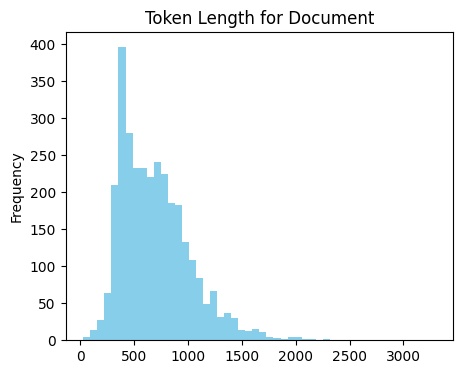

count    3144.000000
mean      703.102099
std       340.832633
min        27.000000
25%       435.000000
50%       648.500000
75%       889.000000
max      3298.000000
Name: token_len, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
eda['token_len'] = eda['tokens'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['token_len'].plot.hist(bins=50, color='skyblue')
plt.title("Token Length for Document")
plt.grid(False)
plt.show()

eda['token_len'].describe()

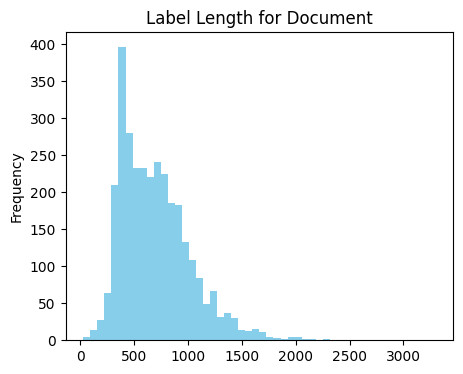

count    3144.000000
mean      703.102099
std       340.832633
min        27.000000
25%       435.000000
50%       648.500000
75%       889.000000
max      3298.000000
Name: label_len, dtype: float64

In [ ]:
eda['label_len'] = eda['labels'].map(lambda x: len(x))
plt.figure(figsize=(5, 4))
eda['label_len'].plot.hist(bins=50, color='skyblue')
plt.title("Label Length for Document")
plt.grid(False)
plt.show()

eda['label_len'].describe()

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_bar_chart(data, target_column, title, xlabel, ylabel):
    target = data[target_column].value_counts(sort=False).reset_index(name='total')
    ax = sns.barplot(
        data=target,
        y='total',
        x=target_column,
        hue=target_column,
        palette='cool',
        estimator=lambda x: sum(x)*100.00/target['total'].sum())
    plt.tight_layout()
    plt.xlabel(xlabel, fontdict={'weight': 'bold'})
    plt.ylabel(ylabel, fontdict={'weight': 'bold'})
    plt.title(title)
    plt.xticks(rotation=0)
    plt.tick_params(axis='both', which='major', labelsize=9)
    for index, row in target.iterrows():
        y = row.total*100.00/target['total'].sum()
        ax.text(row.name, y + 0.15, f'{y:.2f}%', fontsize=9)
    ax.get_legend().remove()
    plt.show()

In [ ]:
def plot_non_pii_entity_doc(df):
    df['non_pii_entity_only'] = df['labels'].apply(lambda x: sum(label=='O' for label in x)==len(x))
    plot_bar_chart(df, 'non_pii_entity_only', "% of Documents with Non-PII Entity ('O' Label) Only", "Non-PII Entity", "Percentage")
    print(df['non_pii_entity_only'].value_counts())

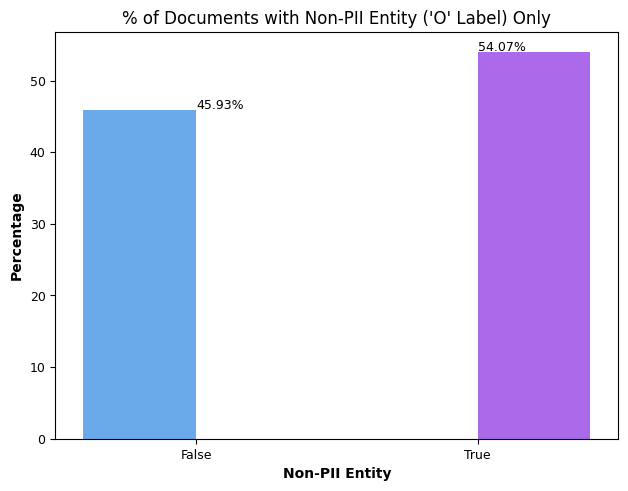

non_pii_entity_only
True     1700
False    1444
Name: count, dtype: int64


In [ ]:
plot_non_pii_entity_doc(eda)

In [ ]:
from collections import Counter
# label value counts on the train data
labels_chained = chain.from_iterable(eda['labels'])
label_counts = Counter(labels_chained)
label_counts

Counter({'O': 2201178,
         'B-NAME_STUDENT': 4491,
         'I-NAME_STUDENT': 2103,
         'I-STREET_ADDRESS': 1437,
         'B-USERNAME': 318,
         'B-STREET_ADDRESS': 218,
         'B-ID_NUM': 210,
         'B-EMAIL': 194,
         'I-PHONE_NUM': 163,
         'B-PHONE_NUM': 124,
         'B-URL_PERSONAL': 115,
         'I-URL_PERSONAL': 1,
         'I-ID_NUM': 1})

In [ ]:
# Extract all unique labels from data
all_labels = sorted(list(set(chain(*[x["labels"] for x in data]))))

# Create label-to-id and id-to-label mappings
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

# Define target labels
target = [
    'B-NAME_STUDENT', 'I-NAME_STUDENT',
    'B-EMAIL',
    'B-USERNAME',
    'B-ID_NUM', 'I-ID_NUM',
    'B-PHONE_NUM', 'I-PHONE_NUM',
    'B-URL_PERSONAL',
    'B-STREET_ADDRESS', 'I-STREET_ADDRESS'
]

In [ ]:
# Initialize the tokenizer for the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(CFG.checkpoint, max_length=512)

# Create a dataset dictionary containing essay data and corresponding labels
ds = Dataset.from_dict({
    "full_text": [x["full_text"] for x in data],
    "document": [str(x["document"]) for x in data],
    "tokens": [x["tokens"] for x in data],
    "trailing_whitespace": [x["trailing_whitespace"] for x in data],
    "provided_labels": [x["labels"] for x in data],
})

# Tokenize the essays and assign corresponding labels to the tokens
ds = ds.map(dp.tokenize,
            fn_kwargs={"tokenizer": tokenizer, "label2id": label2id, "max_length": CFG.max_len},
            num_proc=CFG.workers)

/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map (num_proc=8):   0%|          | 0/3144 [00:00<?, ? examples/s]

In [ ]:
gc.collect()

12998

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

class ModelDevelopment:
    def __init__(self, CFG):
        self.CFG = CFG

    def compute_metrics(self, p, all_labels, beta=1):
        # Unpack predictions and labels
        predictions, labels = p

        # Convert predictions to class indices
        predictions = np.argmax(predictions, axis=2)

        # Remove ignored index (-100, special tokens)
        true_predictions = [
            [all_labels[p] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [all_labels[l] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        # Flatten true predictions and true labels
        flat_true_predictions = [label for sublist in true_predictions for label in sublist]
        flat_true_labels = [label for sublist in true_labels for label in sublist]

        # Calculate the Fβ score
        precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_true_predictions, average='weighted', labels=all_labels)
        fbeta = (1 + beta*2) * (precision * recall) / ((beta*2 * precision) + recall)

        # Return Fβ score as a dictionary
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'fbeta':fbeta
        }
    def evaluate_model(self, model, ds, tokenizer, id2label, label2id, all_labels, beta=1):
        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        trainer = Trainer(
            model=model,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Evaluate the model on the training dataset
        train_metrics = trainer.evaluate(ds)

        return train_metrics


    def train_and_save_model(self, ds, tokenizer, id2label, label2id, all_labels, beta=1):
        model = AutoModelForTokenClassification.from_pretrained(
            self.CFG.checkpoint,
            num_labels=len(all_labels),
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )

        collator = DataCollatorForTokenClassification(tokenizer, pad_to_multiple_of=16)

        # Define training arguments, derived from the configuration class
        args = TrainingArguments(
            output_dir=self.CFG.output_dir,
            fp16=True,
            learning_rate=self.CFG.learning_rate,
            num_train_epochs=self.CFG.epochs,
            per_device_train_batch_size=self.CFG.batch_size,
            gradient_accumulation_steps=self.CFG.grad_steps,
            report_to="none",
            evaluation_strategy="no",
            do_eval=False,
            seed=self.CFG.seed,
            save_total_limit=1,
            logging_steps=self.CFG.log_steps,
            lr_scheduler_type='cosine',
            metric_for_best_model="f1",
            greater_is_better=True,
            warmup_ratio=self.CFG.warmup_ratio,
            weight_decay=self.CFG.weight_decay
        )

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=ds,
            data_collator=collator,
            tokenizer=tokenizer,
            compute_metrics=partial(self.compute_metrics, all_labels=all_labels, beta=beta)
        )

        # Train and save the model and model tokenizer
        # Train the model and log training metrics
        trainer.train()



        trainer.save_model(self.CFG.output_name)
        tokenizer.save_pretrained(self.CFG.output_name)
        train_metrics = self.evaluate_model(model, ds, tokenizer, id2label, label2id, all_labels, beta=beta)
        print("Training Metrics:")
        print(train_metrics)

md = ModelDevelopment(CFG)

In [ ]:
md.train_and_save_model(ds, tokenizer, id2label, label2id, all_labels, beta=1)

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
100,1.023300
200,0.025800
300,0.013300
400,0.011100
500,0.009000
600,0.004800
700,0.005500
800,0.002500
900,0.003900
1000,0.003700


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Training Metrics:
{'eval_loss': 0.0015410877531394362, 'eval_precision': 0.9996553574749155, 'eval_recall': 0.9996538773908351, 'eval_f1': 0.9996525989200135, 'eval_fbeta': 0.9996543707517082, 'eval_runtime': 96.7549, 'eval_samples_per_second': 32.494, 'eval_steps_per_second': 4.062}


In [ ]:
import matplotlib.pyplot as plt

# Provided step and training loss values
steps = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200,
         1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300,2358]
loss_values = [1.586100, 0.030100, 0.014600, 0.011600, 0.008900, 0.004200,
               0.005100, 0.003900, 0.003400, 0.003800, 0.003800, 0.003200,
               0.005000, 0.004300, 0.002500, 0.001900, 0.002100, 0.003500,
               0.002300, 0.001900, 0.001300, 0.002200, 0.001200,0.001100]

# Calculate corresponding epochs using steps per epoch
steps_per_epoch = 786
epochs = [step / steps_per_epoch for step in steps]

# Select epochs to plot
#selected_epochs = [3]  # Choose epochs for plotting (1-based index)

# Filter loss values for selected epochs
selected_loss = [loss_values[steps.index(epoch * steps_per_epoch)] for epoch in selected_epochs]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_values, label='Training Loss', linestyle='-', color='b')
#plt.scatter(selected_epochs, selected_loss, color='r')

# Annotate the selected points
for i, epoch in enumerate(selected_epochs):
    plt.annotate(f'({epoch}, {selected_loss[i]:.4f})', (epoch, selected_loss[i]),
                 textcoords="offset points", xytext=(-15, -10), ha='center')

plt.title('Epoch vs. Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
#plt.grid(True)
plt.show()
